In [1]:
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)
function f(x, y; scale=1)
    r = sqrt(x^2 + y^2)
    if r1 < r < r2
        1*scale
    else
        0
    end
end


f (generic function with 1 method)

In [2]:
interionic_spacing = .2
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = 1
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end


# r1 = .45
# r2 = .55
# decay = .01

r1 = .45
r2 = .55
decay = .1
function annulus(ρ, θ)
    mid = r1 + .5  * (r2 - r1)
    max = (-1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1))))
    ((-1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))))/max
end

annulus (generic function with 1 method)

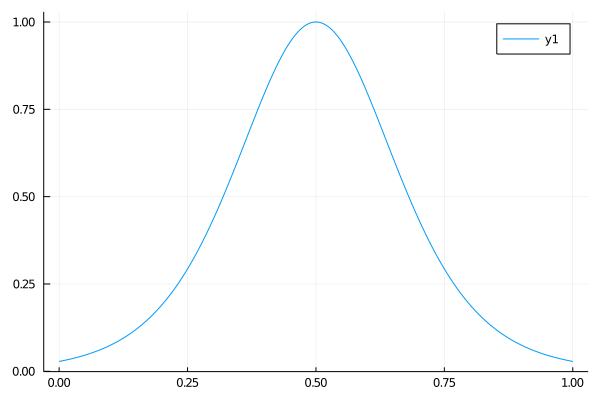

In [3]:
using Plots
rs = range(0, 1, step=.001)
plot(rs, [annulus(r, 0) for r in rs])

In [4]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end

Z (generic function with 1 method)

In [5]:
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ)
        y = ρ * sin(θ)
        Z(n, m, ρ, θ) * annulus(ρ, θ) * ρ
    end
    rtn
end

integrand (generic function with 1 method)

In [112]:
using Cubature
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*2) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end
max_n = 60
data = [cond_eval(i, 0) for i in range(0, max_n, step=1)]

61-element Array{Float64,1}:
     0.40260770133448026
     0.0
    -0.3939554706274166
     0.0
    -0.27236842554672247
     0.0
     0.5064091670148884
     0.0
    -0.22022306609823647
     0.0
    -0.0808451013188882
     0.0
     0.14513535418360807
     ⋮
     0.0
     0.17000331009125869
     0.0
     0.755235871333623
     0.0
     0.19490755029838022
     0.0
    18.828012016424932
     0.0
   162.34063680449788
     0.0
 -2870.5576974620494

In [113]:
function recon(ρ, ϕ)
    t = 0
    for (n, el) in enumerate(data)
        t += el*Z(n-1,0,ρ, 0)
    end
    t
end


recon (generic function with 1 method)

In [114]:
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end


sample_across_unit_disk (generic function with 1 method)

In [115]:
num_points = 100
xx, yy, samples =  sample_across_unit_disk(recon, num_points)

([-1.0, -0.9797979797979798, -0.9595959595959596, -0.9393939393939394, -0.9191919191919192, -0.898989898989899, -0.8787878787878788, -0.8585858585858586, -0.8383838383838383, -0.8181818181818182  …  0.8181818181818182, 0.8383838383838383, 0.8585858585858586, 0.8787878787878788, 0.898989898989899, 0.9191919191919192, 0.9393939393939394, 0.9595959595959596, 0.9797979797979798, 1.0], [-1.0, -0.9797979797979798, -0.9595959595959596, -0.9393939393939394, -0.9191919191919192, -0.898989898989899, -0.8787878787878788, -0.8585858585858586, -0.8383838383838383, -0.8181818181818182  …  0.8181818181818182, 0.8383838383838383, 0.8585858585858586, 0.8787878787878788, 0.898989898989899, 0.9191919191919192, 0.9393939393939394, 0.9595959595959596, 0.9797979797979798, 1.0], BigFloat[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [116]:
xx, yy, samples2 =  sample_across_unit_disk(annulus, num_points)

([-1.0, -0.9797979797979798, -0.9595959595959596, -0.9393939393939394, -0.9191919191919192, -0.898989898989899, -0.8787878787878788, -0.8585858585858586, -0.8383838383838383, -0.8181818181818182  …  0.8181818181818182, 0.8383838383838383, 0.8585858585858586, 0.8787878787878788, 0.898989898989899, 0.9191919191919192, 0.9393939393939394, 0.9595959595959596, 0.9797979797979798, 1.0], [-1.0, -0.9797979797979798, -0.9595959595959596, -0.9393939393939394, -0.9191919191919192, -0.898989898989899, -0.8787878787878788, -0.8585858585858586, -0.8383838383838383, -0.8181818181818182  …  0.8181818181818182, 0.8383838383838383, 0.8585858585858586, 0.8787878787878788, 0.898989898989899, 0.9191919191919192, 0.9393939393939394, 0.9595959595959596, 0.9797979797979798, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


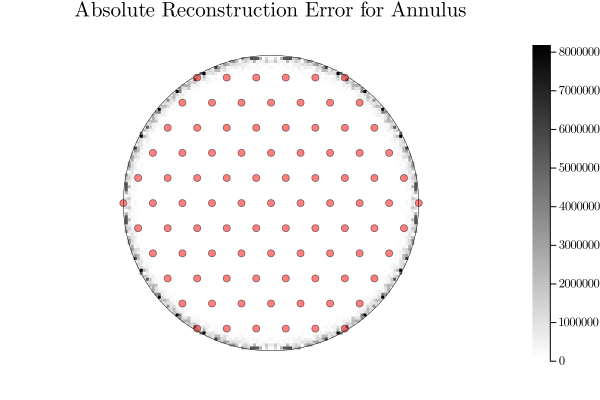

In [117]:
using LaTeXStrings
max = maximum(amp*abs.(samples-samples2))
p = palette([:white, :black], 100)
plot(heatmap(xx, yy, amp*abs.(samples-samples2), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Annulus}", fontfamily="Computer Modern")
p = palette([:white, :red], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=.5)
p = palette([:white, :black], 100)
scatter!(x/radius, y/radius, marker_z = [max for _ in x], c=p, alpha=0)
plot!(circleShape(0, 0, 1), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, fontfamily="Computer Modern", right_margin = 3Plots.mm)

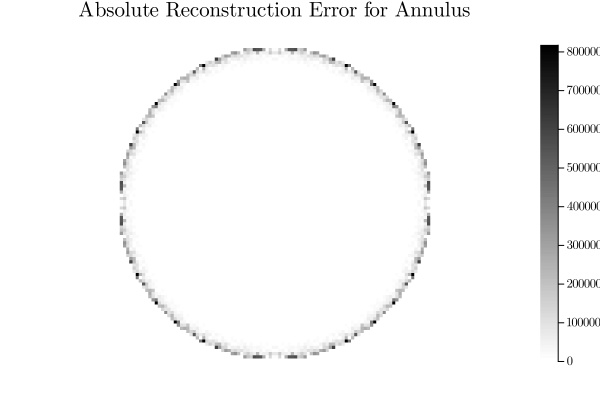

In [118]:
using LaTeXStrings
p = palette([:white, :black], 100)
plot(heatmap(xx, yy, abs.(samples-samples2), c=p),aspectratio=true, legend=false, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Absolute Reconstruction Error for Annulus}", fontfamily="Computer Modern")

In [119]:
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)
function f(x, y; scale=1)
    r = sqrt(x^2 + y^2)
    if r1 < r < r2
        1*scale
    else
        0
    end
end


f (generic function with 1 method)

In [120]:
interionic_spacing = .2
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = 1
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end

# using Plots
# gr() # We will continue onward using the GR backend
# plot(heatmap(xs, ys, f, alpha=.1; c=palette([:white, :blue], 2)))
# plot!(x, y, seriestype = :scatter, title = "Top View of Penning Trap", legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)

#plot!(arcshape(0,2π), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none)

circleShape (generic function with 1 method)

In [121]:
function plot_triangles_across_unit_disk(f, x, y)
    infids = []
    ψ1s = []
    ψ2s = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        infid, ψ1, ψ2 = f(ρ, ϕ)
        push!(infids, infid)
        push!(ψ1s, ψ1)
        push!(ψ2s, ψ2)
        end
    infids, ψ1s, ψ2s
end
# function plot_triangles_across_unit_disk(f, x, y)
#     ψ1s = []
#     for (i, xx) in enumerate(x)
#         print(i)
#         ρ = sqrt(xx^2 + y[i]^2)
#         ϕ = atan(y[i], xx)
#         ψ1 = f(ρ, ϕ)
#         push!(ψ1s, ψ1)
#         end
#    ψ1s
# end

plot_triangles_across_unit_disk (generic function with 1 method)

In [122]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    print(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    Pevens = []
    eventuples = []
    for (m, zeven) in enumerate(zernike_coefficients_even)
        meven = m - 1
        push!(Pevens, [zeven[i] * R(i-1, meven, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = sum(Pevens[i])
        push!(eventuples, (i - 1, total, rotationeven))
    end
    eventuples # No odd tuples, so we'll leave it simple. (In fact, only m=0 again but we'll test this.)
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [123]:
Γ = 1/62
ω = 2*π*180E3
θ = 0.;
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
scale = 1
zernikeeven = []
zernikeodd = []
amp = .01
μ = 0
order =  0

function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        infid = 1 - real(fidelity(ψ1, ψ2))
    return infid, ψ1, ψ2
    end
end

function across_disk(F1)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
    return ψ1
    end
end


U = 2 * π * 10E3
evolution_time = π/(2*U*amp)

step_size = evolution_time/1
T = [0.0:step_size:evolution_time;];

function annulus_spin_profile(ρ, ϕ)
    ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
    H(t, _) = sin(annulus(ρ, ϕ)) * sigmaz(b), [], []
    evolution_time = step_size = π/2
    T = [0.0:step_size:evolution_time;];
    _, ψ = timeevolution.master_dynamic(T, ψ0, H)
    last(ψ)
end

function evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    U * sin(amp*recon(ρ, ϕ))
end

exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, [], U, θ, 0., ω, b)

(::var"#evaluator#150"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Any,1},Array{Any,1},Float64,Float64,Float64,Float64,SpinBasis{1//2,Int64}}) (generic function with 1 method)

In [124]:
annulus(r1 + .5(r2-r1), 0)

1.0

In [125]:
function plot_triangles_across_unit_disk(f, x, y)
    infids = []
    ψ1s = []
    ψ2s = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        infid, ψ1, ψ2 = f(ρ, ϕ)
        push!(infids, infid)
        push!(ψ1s, ψ1)
        push!(ψ2s, ψ2)
        end
    infids, ψ1s, ψ2s
end

plot_triangles_across_unit_disk (generic function with 1 method)

In [ ]:
infid, annulus_vals, exact = plot_triangles_across_unit_disk(infidelity_across_disk(annulus_spin_profile, exact_evolution_evaluator), x, y);

1Complex{Float64}[0.4999999999999999 + 0.0im 0.49803389476289955 - 0.04429717441867533im; 0.49803389476289955 + 0.04429717441867533im 0.4999999999999999 + 0.0im]Complex{Float64}[0.49997983911614924 + 9.828320248833486e-17im 0.39457456815908964 + 0.3070340054464253im; 0.39457456815908964 - 0.3070340054464253im 0.5000201608838508 - 2.5919510435564972e-17im]2Complex{Float64}[0.4999999999999999 + 0.0im 0.41848215427654323 - 0.2736287224521383im; 0.41848215427654323 + 0.2736287224521383im 0.4999999999999999 + 0.0im]Complex{Float64}[0.4999798391161495 + 1.0532974490772855e-16im -0.49620515019117184 - 0.06117391728702713im; -0.49620515019117184 + 0.06117391728702713im 0.5000201608838507 - 3.9688873038672927e-17im]3Complex{Float64}[0.4999999999999999 + 0.0im -0.29536019233674854 - 0.4034379765444427im; -0.29536019233674854 + 0.4034379765444427im 0.4999999999999999 + 0.0im]Complex{Float64}[0.4999798391161495 + 6.011956440500595e-17im -0.36805142570216676 + 0.33837280625238836im; -0.368051425702

Complex{Float64}[0.4999999999999999 + 0.0im 0.16030933965234517 - 0.47360411283691944im; 0.16030933965234517 + 0.47360411283691944im 0.4999999999999999 + 0.0im]Complex{Float64}[0.4999798391161493 - 4.348123290157269e-18im 0.4954725685741585 - 0.06686545276460397im; 0.4954725685741585 + 0.06686545276460397im 0.50002016088385 + 4.809826900526684e-17im]25Complex{Float64}[0.4999999999999999 + 0.0im 0.48663429078427334 - 0.11483495138843516im; 0.48663429078427334 + 0.11483495138843516im 0.4999999999999999 + 0.0im]Complex{Float64}[0.4999798391161496 - 9.027170936005926e-17im 0.3404360916638251 - 0.3661601369068526im; 0.3404360916638251 + 0.3661601369068526im 0.5000201608838508 + 8.662772077077079e-17im]26Complex{Float64}[0.4999999999999999 + 0.0im 0.39681967960481995 - 0.30419422730167733im; 0.39681967960481995 + 0.30419422730167733im 0.4999999999999999 + 0.0im]Complex{Float64}[0.4999798391161498 - 4.58316449448366e-17im -0.49762842840879357 - 0.0482201653830674im; -0.49762842840879357 + 0.0

[0.4999999999999999 + 0.0im 0.47546535825800346 - 0.15470194505356105im; 0.47546535825800346 + 0.15470194505356105im 0.4999999999999999 + 0.0im]Complex{Float64}[0.4999798391161498 - 3.6481401595594986e-17im -0.3657067075230085 + 0.3409330867730008im; -0.3657067075230085 - 0.3409330867730008im 0.5000201608838506 + 7.999209938844411e-17im]48Complex{Float64}[0.4999999999999999 + 0.0im 0.473969680476372 - 0.15922543963832866im; 0.473969680476372 + 0.15922543963832866im 0.4999999999999999 + 0.0im]Complex{Float64}[0.49997983911614946 + 7.595685269655155e-17im 0.4957280106458306 + 0.06489493728849956im; 0.4957280106458306 - 0.06489493728849956im 0.5000201608838504 + 1.0150323173857852e-17im]49Complex{Float64}[0.4999999999999999 + 0.0im 0.07469420969361068 - 0.4943892113519475im; 0.07469420969361068 + 0.4943892113519475im 0.4999999999999999 + 0.0im]Complex{Float64}[0.49997983911614957 + 1.8607788522828138e-18im -0.21725686541724426 + 0.45029033371584076im; -0.21725686541724426 - 0.450290333715

In [ ]:
zannulus = [real(tr([[0, 1] [1, 0]] * s)) for s in annulus_vals];
zseq  = [real(tr([[0, 1] [1, 0]] * s)) for s in exact];

In [ ]:
using LaTeXStrings
function phase(x, y)
    ρ = sqrt(x^2 + y^2)/scale
    mid = r1 + .5  * (r2 - r1)
    max = (1 - 1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1)))) - 1
    if ρ > 1
        -1
    else
        2*((1 - 1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))) - 1)/max - 1
    end
end
p = palette([:white, :black], 100);
scale = 2
plot(heatmap(scale*xs, scale*ys, phase; c=palette([:white, :red], 100, alpha=.5)))
scatter!(scale*x, scale*y, marker_z = zseq, c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Annulus}", fontfamily="Computer Modern")

In [ ]:
using LaTeXStrings
z = infid
function phase(x, y)
    ρ = sqrt(x^2 + y^2)/scale
    mid = r1 + .5  * (r2 - r1)
    max = (1 - 1/(1 + exp(-1/decay*(mid-r2))) +   1/(1 + exp(-1/decay*(mid-r1)))) - 1
    if ρ > 1
        minimum(log.(10, z))
    else
        (maximum(log.(10, z)) - minimum(log.(10, z)))*((1 - 1/(1 + exp(-1/decay*(ρ-r2))) +   1/(1 + exp(-1/decay*(ρ-r1)))) - 1)/max + minimum(log.(10, z))
    end
end
scale = 2
plot(heatmap(scale*xs, scale*ys, phase; c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = log.(10, z), c=palette([:white, :black], 100))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Annulus}", fontfamily="Computer Modern")

In [ ]:
1-maximum(z)